<a href="https://colab.research.google.com/github/nickplas/Intro_to_ML_24-25/blob/main/notebooks/Lab_6_DecisionTreeNaiveBayes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Classification with Decision Trees and Naive Bayes

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.compose import ColumnTransformer
import pandas as pd
from sklearn.tree import DecisionTreeClassifier,plot_tree
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
from sklearn.naive_bayes import CategoricalNB, GaussianNB, ComplementNB, MultinomialNB, BernoulliNB
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree
import numpy.linalg as LA


Import and pre-process the data using `pandas`.
Data source: https://archive-beta.ics.uci.edu/dataset/73/mushroom

For practicality, it also on github (csv format, with features names): https://github.com/LucaPennella/Intro_to_ML_23-24/blob/main/data/Mushroom.csv

In [136]:
FFILE = './Mushrooms.csv'
if os.path.isfile(FFILE):
    print("File already exists")
    if os.access(FFILE, os.R_OK):
        print ("File is readable")
    else:
        print ("File is not readable, removing it and downloading again")
        !rm FFILE
        !wget "https://raw.githubusercontent.com/GaiaSaveri/intro-to-ml/main/data/Mushroom.csv"
else:
    print("Either the file is missing or not readable, download it")
    !wget "https://raw.githubusercontent.com/GaiaSaveri/intro-to-ml/main/data/Mushroom.csv"

Either the file is missing or not readable, download it


"wget" non � riconosciuto come comando interno o esterno,
 un programma eseguibile o un file batch.


Divide features and labels and split the dataset into train and test.

In [137]:
train_data_m=pd.read_csv("./Mushroom.csv")
train_data_m.head()  # viewing some row of the dataset

,CLASS,CAP-SHAPE,CAP-SURF,CAP-COLOR,BRUISES,ODOR,GILL-ATTACH,GILL-SPACE,GILL-SIZE,GILL-COLOR,...,STALK-SURF-BELOW,STALK-COLOR-ABOVE,STALK-COLOR-BELOW,VEIL-TYPE,VEIL-COLOR,RING-NUM,RING-TYPE,SPORE-PRINT-COLOR,POP,HABIT
0,EDIBLE,CONVEX,SMOOTH,WHITE,BRUISES,ALMOND,FREE,CROWDED,NARROW,WHITE,...,SMOOTH,WHITE,WHITE,PARTIAL,WHITE,ONE,PENDANT,PURPLE,SEVERAL,WOODS
1,EDIBLE,CONVEX,SMOOTH,WHITE,BRUISES,ALMOND,FREE,CROWDED,NARROW,WHITE,...,SMOOTH,WHITE,WHITE,PARTIAL,WHITE,ONE,PENDANT,BROWN,SEVERAL,WOODS
2,EDIBLE,CONVEX,SMOOTH,WHITE,BRUISES,ALMOND,FREE,CROWDED,NARROW,PINK,...,SMOOTH,WHITE,WHITE,PARTIAL,WHITE,ONE,PENDANT,PURPLE,SEVERAL,WOODS
3,EDIBLE,CONVEX,SMOOTH,WHITE,BRUISES,ALMOND,FREE,CROWDED,NARROW,PINK,...,SMOOTH,WHITE,WHITE,PARTIAL,WHITE,ONE,PENDANT,BROWN,SEVERAL,WOODS
4,EDIBLE,CONVEX,SMOOTH,WHITE,BRUISES,ALMOND,FREE,CROWDED,NARROW,BROWN,...,SMOOTH,WHITE,WHITE,PARTIAL,WHITE,ONE,PENDANT,PURPLE,SEVERAL,WOODS


In [138]:
train_data_m.shape

(8416, 23)

In [139]:
# use first 5000 data points for training and the rest for test
train_data_m = train_data_m.sample(frac=1,random_state=0).reset_index(drop=True) # random shufle
#frac -> proporzione di righe da campionare
#random_state -> seed per la scelta casuale per lo shuffle
#se aggiungo un parametro sample(n = , rand) -> scelgo il numero di righe che deve avere il risultato. esempio lo stesso numro di righe di un altro dataset
#non posso usare n e frac assieme
#mi serve per la separazione train test, sostituibile col metodo in scikitlearn
train_data_m.head()

,CLASS,CAP-SHAPE,CAP-SURF,CAP-COLOR,BRUISES,ODOR,GILL-ATTACH,GILL-SPACE,GILL-SIZE,GILL-COLOR,...,STALK-SURF-BELOW,STALK-COLOR-ABOVE,STALK-COLOR-BELOW,VEIL-TYPE,VEIL-COLOR,RING-NUM,RING-TYPE,SPORE-PRINT-COLOR,POP,HABIT
0,POISONOUS,CONVEX,SCALY,BROWN,NO,SPICY,FREE,CLOSE,NARROW,BUFF,...,SMOOTH,WHITE,PINK,PARTIAL,WHITE,ONE,EVANESCENT,WHITE,SEVERAL,WOODS
1,EDIBLE,CONVEX,FIBROUS,RED,BRUISES,NONE,FREE,CLOSE,BROAD,PURPLE,...,SMOOTH,PINK,WHITE,PARTIAL,WHITE,ONE,PENDANT,BROWN,SEVERAL,WOODS
2,POISONOUS,FLAT,FIBROUS,GRAY,NO,FOUL,FREE,CLOSE,BROAD,CHOCOLATE,...,SILKY,BUFF,PINK,PARTIAL,WHITE,ONE,LARGE,CHOCOLATE,SOLITARY,GRASSES
3,EDIBLE,FLAT,FIBROUS,BROWN,NO,NONE,FREE,CROWDED,BROAD,BROWN,...,SMOOTH,WHITE,WHITE,PARTIAL,WHITE,ONE,EVANESCENT,BROWN,ABUNDANT,GRASSES
4,EDIBLE,CONVEX,FIBROUS,BROWN,BRUISES,NONE,FREE,CLOSE,BROAD,PURPLE,...,SMOOTH,GRAY,WHITE,PARTIAL,WHITE,ONE,PENDANT,BROWN,SEVERAL,WOODS


In [140]:
# Create a training set 'train' by selecting the first 5000 rows of the DataFrame 'train_data_m'
train = train_data_m.iloc[:5000, :]

# Create a test set 'test' by selecting rows from position 5000 onwards until the end of 'train_data_m'
test = train_data_m.iloc[5000:, :]

## Decision Trees

**Using Decision Trees for Classification with ID3 (Iterative Dichotomiser 3)**

Here's a breakdown:

**Recall:**

- **Decision Building:**
  - We build a decision tree from a dataset.
  - Each node in the tree is like a checkpoint, helping us make a decision (internal node) or representing an outcome (leaves).

- **ID3 Algorithm:**
  - ID3 is a top-down approach (starting from the root) and a greedy algorithm (only considers the current step when choosing the best features) for building decision trees.

- **Feature Selection:**
  - At each step, features are grouped based on **information gain**.
  - Information gain helps us decide which feature is the most useful for making decisions.
  - **Entropy Formula:** $H(S) = \sum_{i=1}^D -p_i \log p_i$, where $p_i$ is the proportion of each category.
  - **Information Gain Formula:** $IG(S, j)=H(s) - \sum_j \frac{|S_j|}{|S|}H(S_j)$

- **Node Selection:**
  - A node becomes a leaf if all the data in that node belong to the same class.

- **Tree Construction:**
  - Repeat this process until the tree has only leaf nodes or until we've used all available features.

We start at the top and make decisions at each step based on the most helpful information. This continues until all our decisions (leaves) are clear or until we've used up all the information we have.

Functions for building the decision tree:

In [141]:
# compute H(S)
def calc_total_entropy(train_data, label, class_list):
    """
    Parameters
    ----------
    train_data : matrix n_data x n_features
        Matrix containing the training dataset
    label : int
        Feature used as label
    class_list : list of str
        Possible values of the label
    """
    count = train_data.shape[0] # Number of points considered
    entropy = 0

    for c in class_list:  # For each possible class in the label
        class_count = train_data[train_data[label] == c].shape[0]  # Count of rows with class c
        entropy_class = - (class_count / count) * np.log2(class_count / count)  # Entropy
        entropy += entropy_class

    return entropy


In [142]:
# compute H(S_j)
def calc_entropy(feature_value_data, label, class_list):
    """
    Parameters
    ----------
    feature_value_data : matrix n_data_selected x n_features
        Matrix containing the training points having a certain value of feature j
    label : int
        Feature used as label
    class_list : list of str
        Possible values of the label
    """
    class_count = feature_value_data.shape[0] # Number of points considered
    entropy = 0

    for c in class_list:  # For each possible class in the label
        label_class_count = feature_value_data[feature_value_data[label] == c].shape[0]  # Count of rows with class c
        entropy_class = 0
        if label_class_count != 0:  # Avoid numerical errors
            probability_class = label_class_count / class_count  # Probability of the class
            entropy_class = - probability_class * np.log2(probability_class)  # Entropy
        entropy += entropy_class

    return entropy

The function returns the entropy of the subset based on the specified feature value and its possible classes.

In [143]:
# compute information gain in terms of entropy IG(S, j)
def calc_info_gain(feature_name, train_data, label, class_list):
    """
    Parameters
    ----------
    feature_name : str
        Feature considered for computing information gain (j)
    train_data : matrix n_data x n_features
        Matrix containing the training dataset
    label : int
        Feature used as label
    class_list : list of str
        Possible values of the label
    """
    feature_value_list = train_data[feature_name].unique() # Unique values of the feature
    total_row = train_data.shape[0]
    feature_info = 0.0

    ##### Check for missing values
    a = feature_value_list[feature_value_list=='?']
    t = a.shape[0] # Number of points with missing value

    if t > 0:  # At least a point is missing the entry for this feature
        cmax = 0  # Number of points in the most represented class
        n = -1
        for feature_value in feature_value_list:  # Possible values for the current feature
            n = n + 1
            if feature_value != '?':
                c = train_data[train_data[feature_name] == feature_value].shape[0]
                if c > cmax:
                    cmax = c
                    fmax = feature_value  # Value of the feature with the most points
        # Replace missing values with the most represented feature value
        train_data[feature_name][:] = [fmax if x == '?' else x for x in train_data[feature_name]]

    #####  Now all the data have a value for the feature under analysis
    for feature_value in feature_value_list:
        feature_value_data = train_data[train_data[feature_name] == feature_value]  # Filtering rows with that feature_value
        feature_value_count = feature_value_data.shape[0]  # Number of points having feature value in feature j
        feature_value_entropy = calc_entropy(feature_value_data, label, class_list) # Calculating entropy for the feature value
        feature_value_probability = feature_value_count / total_row
        feature_info += feature_value_probability * feature_value_entropy  # Calculating information of the feature value

    return calc_total_entropy(train_data, label, class_list) - feature_info  # Calculating information gain by subtracting

- **Handling Missing Values:**
  - Check for missing values in the feature, represented by `'?'`.
  - If there are missing values, find the most represented feature value (`fmax`) and replace missing values with it.

- **Information Gain Calculation Loop:**
  - For each unique value of the feature:
    - `feature_value_data`: Filter rows with the current feature value.
    - `feature_value_count`: Number of points having the current feature value.
    - `feature_value_entropy`: Calculate the entropy for the current feature value.
    - `feature_value_probability`: Probability of the current feature value occurring.
    - Add the product of probability and entropy to the total information of the feature (`feature_info`).

In [144]:
# find feature with maximum information gain
def find_most_informative_feature(train_data, label, class_list):
    """
    Parameters
    ----------
    train_data : matrix n_data x n_features
        Matrix containing the training dataset
    label : int
        Feature used as label
    class_list : list of str
        Possible values of the label
    """
    # N.B. label is not a feature, so drop it!
    feature_list = train_data.columns.drop(label) #finding the feature names in the dataset
    max_info_gain = -1
    max_info_feature = None

    for feature in feature_list:  # for each feature in the dataset
        feature_info_gain = calc_info_gain(feature, train_data, label, class_list)
        if max_info_gain < feature_info_gain: # selecting feature name with highest information gain
            max_info_gain = feature_info_gain
            max_info_feature = feature

    return max_info_feature  # returns the name of the feature with the maximum information gain.

In [145]:
# split the tree and check finishing condition
def generate_sub_tree(feature_name, train_data, label, class_list):
    """
    Parameters
    ----------
    feature_name : str
        Feature considered at current node
    train_data : matrix n_data x n_features
        Matrix containing the training dataset
    label : int
        Feature used as label
    class_list : list of str
        Possible values of the label
    """
    feature_value_count_dict = train_data[feature_name].value_counts(sort=False)  # dictionary of the count of unqiue feature value
    tree = {}  # sub tree or node

    for feature_value, count in feature_value_count_dict.items():
        feature_value_data = train_data[train_data[feature_name] == feature_value]  # dataset with only feature_name = feature_value
        assigned_to_node = False  # flag for tracking feature_value is pure class or not
        for c in class_list:  # for each class
            class_count = feature_value_data[feature_value_data[label] == c].shape[0]  # count of class c

            if class_count == count:  # count of (feature_value = count) of class (pure class, any value of the feature represents only one class)
                tree[feature_value] = c  # adding node to the tree
                train_data = train_data[train_data[feature_name] != feature_value]  # removing rows with feature_value
                assigned_to_node = True
        if not assigned_to_node:  # not pure class
            tree[feature_value] = "?" # as feature_value is not a pure class, it should be expanded further,
                                      # so the branch is marking with ?

    return tree, train_data # The function returns the generated subtree (`tree`) and the updated dataset (`train_data`) after removing rows associated with the feature values.

- **Subtree Generation Loop:**
  - For each unique feature value and its count:
    - `feature_value_data`: The subset of the dataset with only the current feature value.
    - `assigned_to_node`: A flag to track whether the feature value represents a pure class.
    - For each class in the class list:
      - `class_count`: The count of the current class in the subset.
      - If the count of the class is equal to the count of the feature value, it's a pure class, and a node is added to the tree.
    - If the feature value is not assigned to a node (not a pure class), a branch is marked with "?" in the tree.

In [146]:
# generate the tree
def make_tree(root, prev_feature_value, train_data, label, class_list):
    """
    Parameters
    ----------
    root : dict
        Tree written as dictionary of subtrees (initially {})
    prev_feature_value : str
        Previous value of the pointed node (initially None)
    train_data : matrix n_data x n_features
        Matrix containing the training dataset
    label : int
        Feature used as label
    class_list : list of str
        Possible values of the label
    """
    if train_data.shape[0] != 0:  # if dataset becomes empty after updating
        max_info_feature = find_most_informative_feature(train_data, label, class_list)  # most informative feature
        tree, train_data = generate_sub_tree(max_info_feature, train_data, label, class_list)  # getting tree node and updated dataset
        next_root = None
        if prev_feature_value != None:  # add to intermediate node of the tree
            root[prev_feature_value] = dict()
            root[prev_feature_value][max_info_feature] = tree  # expand the tree
            next_root = root[prev_feature_value][max_info_feature]
        else:  # add to root of the tree
            root[max_info_feature] = tree
            next_root = root[max_info_feature]

        for node, branch in list(next_root.items()):  # iterating the tree node
            if branch == "?":  # if it is expandable
                feature_value_data = train_data[train_data[max_info_feature] == node]  # using the updated dataset
                make_tree(next_root, node, feature_value_data, label, class_list)  # recursive call with updated dataset

- **Tree Generation Steps:**
  - `max_info_feature`: Identifies the most informative feature for the current node.
  - `tree, train_data`: Generates a subtree for the identified feature using the `generate_sub_tree` function and updates the dataset.
  - `next_root`: The subtree corresponding to the current node.

- **Adding to Tree:**
  - If `prev_feature_value` is not `None`, it adds the subtree to the intermediate node of the tree.
  - If `prev_feature_value` is `None`, it adds the subtree to the root of the tree.

- **Recursive Call:**
  - For each node and branch in the current subtree, if the branch is "?" (expandable), it recursively calls the function with the updated dataset. This step continues until the dataset becomes empty or all branches are non-expandable.

In [147]:
# id3 call
def id3(train_data_m, label):
    """
    Parameters
    ----------
    train_data_m : matrix n_data x n_features
        Matrix containing the training dataset
    label : int
        Feature used as label
    """
    train_data = train_data_m.copy()  # getting a copy of the dataset
    tree = {}  # tree which will be updated
    class_list = train_data[label].unique()  # getting unqiue classes of the label
    make_tree(tree, None, train_data, label, class_list)  # start calling recursion
    return tree

- **`id3` Function:**
  - This function is the entry point for the ID3 algorithm. It initializes the tree and calls the `make_tree` function to generate the decision tree recursively.

- **Initialization:**
  - `train_data`: A copy of the original dataset. The copy is made to avoid modifying the original dataset during the tree generation process.
  - `tree`: The variable to store the decision tree, initialized as an empty dictionary.
  - `class_list`: A list of unique classes present in the label.

- **Recursive Tree Generation:**
  - Calls the `make_tree` function with the initial parameters to start the recursive tree generation process. The tree is updated during this process.

Functions for testing the decision tree algorithm:

In [148]:
# prediction from a given instance
def predict(tree, instance):
    """
    Parameters
    ----------
    tree : dict
        Decision tree represented as a dictionary
    instance : dict
        Instance to be classified
    """
    # TODO: Handle missing values or missing label in the training set
    if not isinstance(tree, dict):  # If it is a leaf node
        return tree  # Return the value
    else:
        root_node = next(iter(tree))  # Getting the first key/feature name of the dictionary
        feature_value = instance[root_node]  # Value of the feature
        if feature_value in tree[root_node]:  # Checking if the feature value is in the current tree node
            if (feature_value != "?"):  # & (feature_value in tree.keys())):
                return predict(tree[root_node][feature_value], instance)  # Go to the next feature
        else:
            return None


- **Leaf Node Check:**
  - If the current node in the decision tree is not a dictionary (i.e., a leaf node), it returns the value associated with that node.

- **Non-Leaf Node Processing:**
  - If the current node is a dictionary (non-leaf node), it extracts the feature name of the current node (`root_node`) and the corresponding feature value from the instance.

- **Checking Feature Value in Tree:**
  - It checks if the feature value exists in the current tree node. If it does, and the feature value is not "?" (indicating a missing value), it recursively calls the `predict` function for the next level of the tree.

- **Handling Unknown Feature Values:**
  - If the feature value is not found in the current tree node, it returns `None`, indicating that the tree does not provide a prediction for the given instance.

In [149]:
# accuracy evaluation
def evaluate(tree, test_data_m, label):
    correct_preditct = 0
    wrong_preditct = 0
    for index in range(len(test_data_m.index)):  # for each row in the dataset
        result = predict(tree, test_data_m.iloc[index])  # predict the row
        if result == test_data_m[label].iloc[index]:  # predicted value and expected value is same or not
            correct_preditct += 1  # increase correct count
        else:
            wrong_preditct += 1  # increase incorrect count
    accuracy = correct_preditct / (correct_preditct + wrong_preditct)  # calculating accuracy
    return accuracy

## Naive Bayes

Make classification using the **Naive Bayes** algorithm.

Recall:

* Bayes Theorem: $p(class|data) \propto p(data|class)\cdot p(class)$

This theorem expresses how our belief in the probability of a particular class given some data is proportional to the likelihood of observing that data given the class, multiplied by the prior probability of the class. In other words, it helps us update our beliefs about the probability of a class based on new evidence

* prior ($p(class)$) is just the ratio of the number of datapoints belonging to the class;

The prior probability is simply the ratio of the number of data points belonging to a specific class to the total number of data points. It represents our initial belief in the likelihood of encountering a particular class before considering any additional information.

* to make predictions (i.e. compute the posterior $p(class|data)$) we consider the likelihood of each class ($p(data|class)$) computed as a proportion;

* we work in the log-space so that predictions will be the class maximizing the sum of prior and likelihood.


Function for training the Naive Bayes algorithm:

In [150]:
def train_naive_bayes(train_data, label):
    """
    Parameters
    ----------
    train_data : matrix n_data x n_features
        Matrix containing the training dataset
    label : int
        Feature used as label
    """
    bayes_pi = {}
    bayes_tab = {}
    ntot = len(train_data.index)
    for cl in train_data[label].unique():  # for each possible value of the label
        fl = train_data[label]  # select training points in current class
        ncl = fl[fl==cl].shape[0]  # count number of points in current class
        pcl = ncl/ntot # proportion of points in current class (prior)
        bayes_pi[cl] = pcl
    for col in train_data.columns: # for each feature
        if (col != label):
            dd = pd.crosstab(train_data[label], train_data[col]) # frequency table
            a = np.sum(dd)  # total number of points belonging to a class
            b = np.sum(a[a.keys()!="?"])
            bayes_tab[col] = dd/b # likelihhod of each class

    return bayes_pi, bayes_tab

Function for testing Naive Bayes:

In [151]:
# prediction and accuracy evaluation
def predict_naive_bayes(test_data, bayes_pi, bayes_tab, label):
    ntot = len(test_data.index)
    ncorrect = 0
    for j in range(ntot):
        prob = bayes_pi.copy()
        for col in test_data.columns:
            if (col != label):
                if ((test_data[col].iloc[j]!="?")&(test_data[col].iloc[j] in bayes_tab[col].keys())):
                    for cl in bayes_pi.keys():
                        prob[cl] = prob[cl]*bayes_tab[col][test_data[col].iloc[j]][cl]
        if (test_data[label].iloc[j] == max(prob, key=prob.get)):
            ncorrect = ncorrect + 1
    return (ncorrect/ntot) # accuracy

## Logistic

In [152]:
def sigmoidM(x, w):
    y = 1/(1+np.exp(-np.matmul(x,w)))
    return y

def RidgeLogLoss(x, y, w, lam):
    n = np.shape(x)[0]
    return -(1/n)*np.sum(y*np.log(sigmoidM(x,w)) + (1-y)*np.log(1-sigmoidM(x,w))) + lam*LA.norm(w,2)

def RidgeGradient(w, lam):
    return 2*lam*w

def lassoGradient(w, lam):
    g = np.ones(w.shape)
    g[w < 0.] = -1.0
    return lam*g

def lassoLogLoss(x,y,w,lam):
    n = np.shape(x)[0]
    return -(1/n)*np.sum(y*np.log(sigmoidM(x,w)) + (1-y)*np.log(1-sigmoidM(x,w))) + lam*LA.norm(w,1)

def GDelNet(x, y, iter, gamma, lam, lamr):
    d = np.shape(x)
    loss = np.zeros(iter)
    np.random.seed(123)
    w =  np.random.uniform(0, 0.01, d[1])
    W = np.zeros((d[1], iter))
    for i in range(iter):
        W[:,i] = w
        w = w - (gamma) * ((2/d[0])*(np.transpose(x) @ (sigmoidM(x,w)-y)) + lamr * lassoGradient(w,lam) + (1-lamr) * RidgeGradient(w,lam))
        loss[i] = -(1/d[0])*np.sum(y*np.log(sigmoidM(x,w)) + (1-y)*np.log(1-sigmoidM(x,w))) + (1-lamr)* lam*LA.norm(w,2) + lamr*lam*LA.norm(w,2)

    return W,loss

def get_y_pred(X_train,y_train,iter,gamma,lam,lamr,soglia):
    W, loss = GDelNet(X_train,y_train,iter,gamma,lam,lamr)
    w = W[:,iter-1]
    y_pred = sigmoidM(X_test, w)
    y_pred[y_pred < soglia] = 0.
    y_pred[y_pred >= soglia] = 1.
    return y_pred, loss, w

def print_res(y_true,y_pred,w,loss):
    target_names = ['California', 'Florida']
    print(classification_report(y_true, y_pred, target_names=target_names))
    print(w)
    print(y_pred)
    plt.plot(loss)
    plt.xlabel("Iterazioni")
    plt.ylabel("Loss Value")
    plt.title("Grafico Della Loss")
    plt.show()

def con_matr(y_true,y_pred):
    from sklearn.metrics import confusion_matrix
    import seaborn as sns
    import matplotlib.pyplot as plt
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.xlabel("Predicted labels")
    plt.ylabel("True labels")
    plt.title("Confusion Matrix")
    plt.show()
    

In [153]:
def rocCurve(X_train,X_test,y_train,y_true,iter,gamma,lam,lamr):
    import copy
    Wr, loss = GDelNet(X_train,y_train,iter,gamma,lam,lamr)
    wr = Wr[:,iter-1]
    y_predr = sigmoidM(X_test, wr)
    tpr = []
    fpr = []
    soglie = copy.deepcopy(np.flip(np.sort(y_predr)))
    for soglia in soglie:
        y_pred = copy.deepcopy(y_predr)
        y_pred[y_predr < soglia] = 0.
        y_pred[y_predr >= soglia] = 1.
        tp = 0
        fp = 0
        for i, elem in enumerate(y_pred):
            if elem == y_true[i] and elem == 1.:
                tp = tp + 1
            if elem != y_true[i] and elem == 1.:
                fp = fp + 1 
        p = sum(y_true)
        n = len(y_true) - p
        tpr.append(tp/p)
        fpr.append(fp/n)
    plt.plot(fpr,tpr)
    plt.scatter(fpr, tpr)
    plt.plot(np.linspace(0,1,100),np.linspace(0,1,100))
    plt.xlabel("False Positive Ratio")
    plt.ylabel("True Positive Ratio")
    plt.title("Roc Curve")
    plt.show()  
    return soglie

## Results on Mushroom Dataset

### Decision Tree

In [154]:
tre = id3(train, "CLASS")
print(tre)

C:\Users\pitom\AppData\Local\Temp\ipykernel_12584\2186149166.py:34: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  train_data[feature_name][:] = [fmax if x == '?' else x for x in train_data[feature_name]]


{'ODOR': {'SPICY': 'POISONOUS', 'NONE': {'SPORE-PRINT-COLOR': {'BROWN': 'EDIBLE', 'BLACK': 'EDIBLE', 'WHITE': {'HABIT': {'GRASSES': 'EDIBLE', 'WASTE': 'EDIBLE', 'LEAVES': {'CAP-COLOR': {'BROWN': 'EDIBLE', 'CINNAMON': 'EDIBLE', 'YELLOW': 'POISONOUS', 'WHITE': 'POISONOUS'}}, 'WOODS': {'GILL-SIZE': {'BROAD': 'EDIBLE', 'NARROW': 'POISONOUS'}}, 'PATHS': 'EDIBLE'}}, 'ORANGE': 'EDIBLE', 'BUFF': 'EDIBLE', 'YELLOW': 'EDIBLE', 'GREEN': 'POISONOUS', 'CHOCOLATE': 'EDIBLE'}}, 'FOUL': 'POISONOUS', 'PUNGENT': 'POISONOUS', 'FISHY': 'POISONOUS', 'ANISE': 'EDIBLE', 'CREOSOTE': 'POISONOUS', 'ALMOND': 'EDIBLE', 'MUSTY': 'POISONOUS'}}


In [155]:
accuracy = evaluate(tree, test, "CLASS")
print(accuracy)

0.0


### Naive Bayes

In [156]:
pi, tab = train_naive_bayes(train, "CLASS")

c:\Users\pitom\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
c:\Users\pitom\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
c:\Users\pitom\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old

In [157]:
accuracy = predict_naive_bayes(test, pi, tab,"CLASS")
print(accuracy)

0.9991217798594848


In [158]:
train_data_m=pd.read_csv("./Mushroom.csv")
df = pd.DataFrame(train_data_m)
x = df.drop('CLASS', axis=1)
y = df['CLASS']
encoder = LabelEncoder()
x_encoded = x.apply(encoder.fit_transform)
y_encoded = encoder.fit_transform(y)
X_train, X_test, Y_train, Y_test = train_test_split(x_encoded,y_encoded, test_size=0.2, random_state=90)

<function matplotlib.pyplot.show(close=None, block=None)>

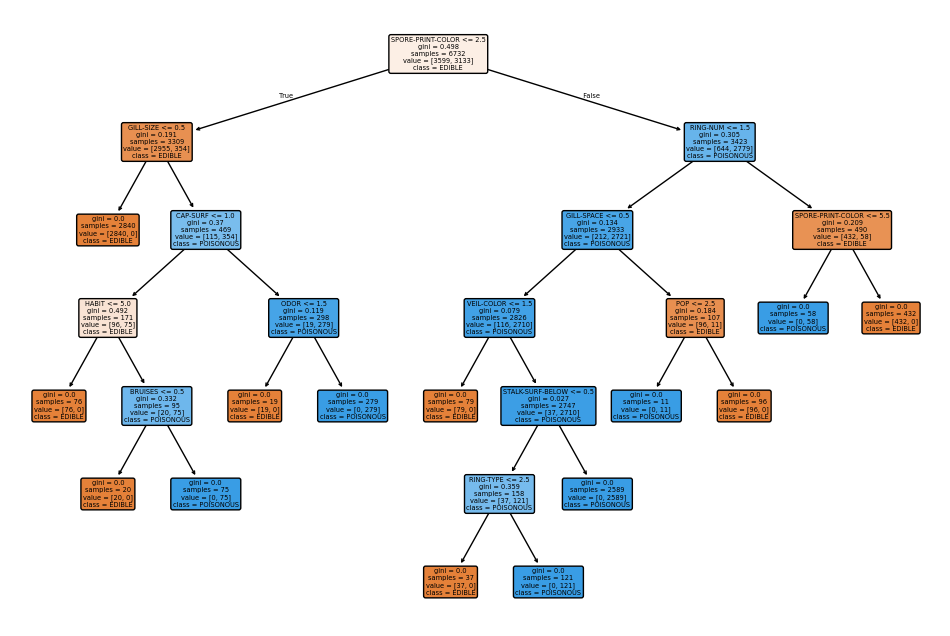

In [159]:
albero = tree.DecisionTreeClassifier()
albero.fit(X_train,Y_train)
plt.figure(figsize=(12,8))
plot_tree(albero, filled=True,feature_names=x.columns,class_names=encoder.classes_, rounded=True)
plt.show

              precision    recall  f1-score   support

      EDIBLE       1.00      1.00      1.00       889
   POISONOUS       1.00      1.00      1.00       795

    accuracy                           1.00      1684
   macro avg       1.00      1.00      1.00      1684
weighted avg       1.00      1.00      1.00      1684



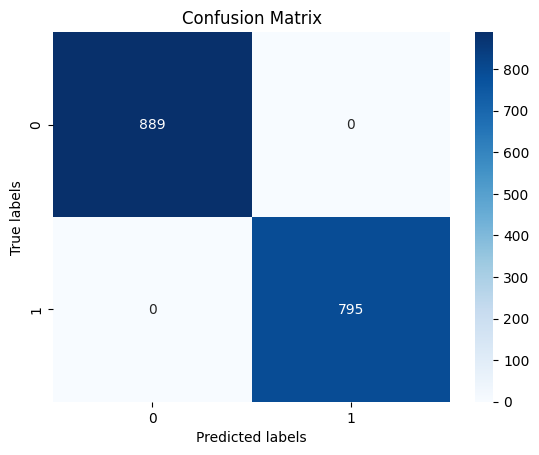

In [160]:
y_pred = albero.predict(X_test)
target = np.unique(y)
print(classification_report(Y_test, y_pred, target_names=np.unique(y)))
con_matr(Y_test,y_pred)

              precision    recall  f1-score   support

      EDIBLE       0.90      0.90      0.90       889
   POISONOUS       0.89      0.89      0.89       795

    accuracy                           0.89      1684
   macro avg       0.89      0.89      0.89      1684
weighted avg       0.89      0.89      0.89      1684



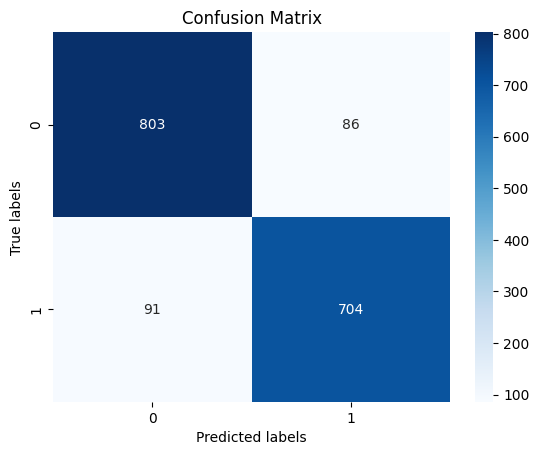

In [161]:
gnbG = GaussianNB()
gnbG.fit(X_test,Y_test)
y_pred = gnbG.predict(X_test)
target = np.unique(y)
print(classification_report(Y_test, y_pred, target_names=np.unique(y)))
con_matr(Y_test,y_pred)

              precision    recall  f1-score   support

      EDIBLE       0.91      1.00      0.95       889
   POISONOUS       1.00      0.88      0.94       795

    accuracy                           0.94      1684
   macro avg       0.95      0.94      0.94      1684
weighted avg       0.95      0.94      0.94      1684



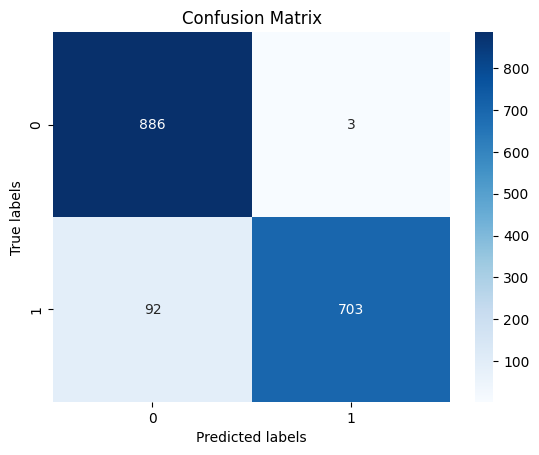

In [162]:
gnbC = CategoricalNB()
gnbC.fit(X_test,Y_test)
y_pred = gnbC.predict(X_test)
target = np.unique(y)
print(classification_report(Y_test, y_pred, target_names=np.unique(y)))
con_matr(Y_test,y_pred)

              precision    recall  f1-score   support

      EDIBLE       0.82      0.86      0.84       889
   POISONOUS       0.84      0.78      0.81       795

    accuracy                           0.82      1684
   macro avg       0.83      0.82      0.82      1684
weighted avg       0.83      0.82      0.82      1684



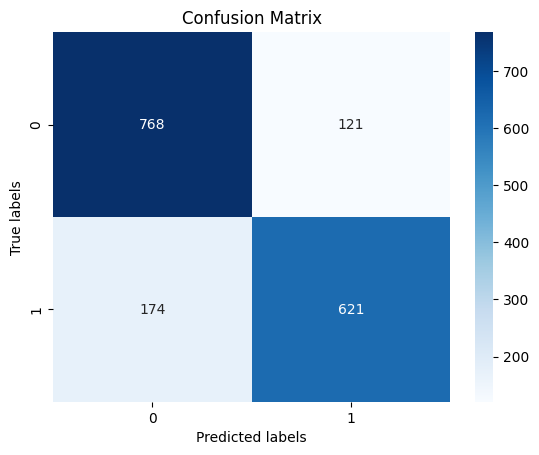

In [163]:
gnbM = MultinomialNB()
gnbM.fit(X_test,Y_test)
y_pred = gnbM.predict(X_test)
target = np.unique(y)
print(classification_report(Y_test, y_pred, target_names=np.unique(y)))
con_matr(Y_test,y_pred)

              precision    recall  f1-score   support

      EDIBLE       0.87      0.90      0.88       889
   POISONOUS       0.88      0.85      0.86       795

    accuracy                           0.87      1684
   macro avg       0.87      0.87      0.87      1684
weighted avg       0.87      0.87      0.87      1684



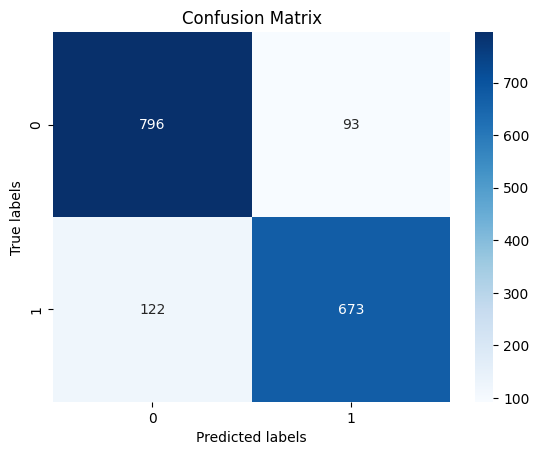

In [164]:
gnbB = BernoulliNB()
gnbB.fit(X_test,Y_test)
y_pred = gnbB.predict(X_test)
target = np.unique(y)
print(classification_report(Y_test, y_pred, target_names=np.unique(y)))
con_matr(Y_test,y_pred)

              precision    recall  f1-score   support

      EDIBLE       1.00      1.00      1.00       889
   POISONOUS       1.00      1.00      1.00       795

    accuracy                           1.00      1684
   macro avg       1.00      1.00      1.00      1684
weighted avg       1.00      1.00      1.00      1684



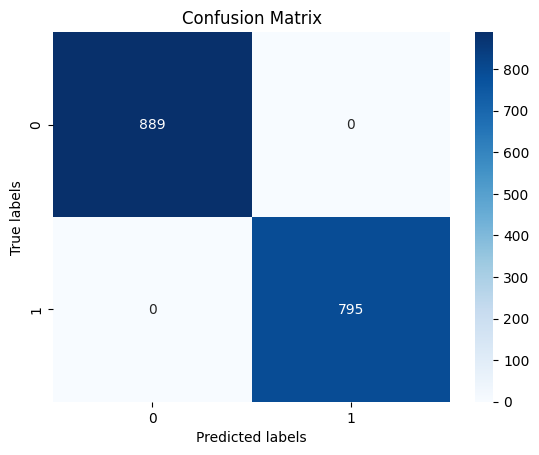

In [165]:
RandF = RandomForestClassifier(n_estimators=10)
RandF.fit(X_train,Y_train)
y_pred = RandF.predict(X_test)
target = np.unique(y)
print(classification_report(Y_test, y_pred, target_names=np.unique(y)))
con_matr(Y_test,y_pred)


In [166]:
iter = 620
gamma = 0.0001
lam = 1

              precision    recall  f1-score   support

  California       0.83      0.76      0.80       889
     Florida       0.76      0.83      0.79       795

    accuracy                           0.80      1684
   macro avg       0.80      0.80      0.80      1684
weighted avg       0.80      0.80      0.80      1684

[ 3.03860327e-06 -2.53521274e-05 -9.40831319e-05 -6.17213737e-05
 -1.00766244e-04  7.68897864e-05 -8.18217621e-05 -1.63555775e-05
 -6.87069670e-03 -1.28366041e-05 -5.28291988e-05 -1.24712451e-06
 -2.84117999e-06 -1.49996294e-03 -3.01332491e-05  7.99540573e-05
  8.73301950e-05 -1.90942381e-05 -3.27341509e-05  1.72071778e-02
 -5.46890339e-05  3.00538627e-05]
8108    1.0
1538    0.0
1545    0.0
542     0.0
312     0.0
       ... 
2365    0.0
2389    0.0
6144    1.0
1861    0.0
6397    1.0
Length: 1684, dtype: float64


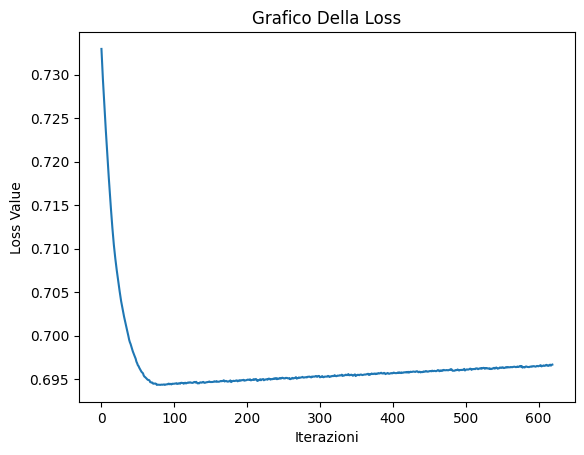

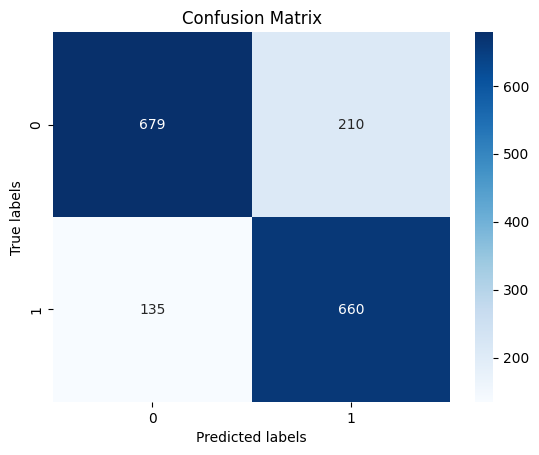

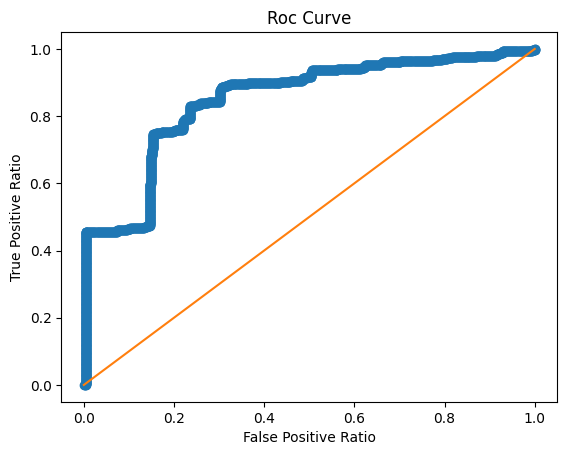

In [168]:
y_pred, loss, w = get_y_pred(X_train,Y_train,iter,gamma,lam,1,soglia=0.5)
print_res(Y_test,y_pred,w,loss)
con_matr(Y_test,y_pred)
soglie = rocCurve(X_train,X_test,Y_train,Y_test,iter,gamma,lam,1)

# Additional Resources



*  [ Decision and Classification Trees: Explained](https://youtu.be/_L39rN6gz7Y?si=nNZVbaBuq28pPXe4)
*   [Entropy (for data science) Explained](https://youtu.be/YtebGVx-Fxw?si=2iDmdSdJgyZ7gVYa)

